# Introduction

This vignette discusses the basics of using Difference-in-Differences (DiD) designs to identify and estimate the average effect of participating in a treatment with a particular focus on tools from the **csdid** package. The background article for it is [Callaway and Sant'Anna (2021), "Difference-in-Differences with Multiple Time Periods"](https://doi.org/10.1016/j.jeconom.2020.12.001).

* The **csdid** package allows for multiple periods and variation in treatment timing

* The **csdid** package allows the parallel trends assumption to hold conditional on covariates

* Treatment effect estimates coming from the **csdid** package do not suffer from any of the drawbacks associated with two-way fixed effects regressions or event study regressions when there are multiple periods / variation in treatment timing

* The **csdid** package can deliver disaggregated *group-time average treatment effects* as well as event-study type estimates (treatment effects parameters corresponding to different lengths of exposure to the treatment) and overall treatment effect estimates.



# Examples with simulated data

Let's start with a really simple example with simulated data.  Here, there are going to be 4 time periods.  There are 4000 units in the treated group that are randomly (with equal probability) assigned to first participate in the treatment (a *group*) in each time period.  And there are 4000 ``never treated'' units.  The data generating process for untreated potential outcomes

$$
  Y_{it}(0) = \theta_t + \eta_i + X_i'\beta_t + v_{it}
$$

This is an example of a very simple model for untreated potential outcomes that is compatible with a conditional parallel trends assumption.  In particular,

* We consider the case where $\eta_i$ can be distributed differently across groups.  This means that comparisons of outcomes in levels between treated and untreated units will not deliver an average treatment effect parameter.

* Next, notice that  $$ \Delta Y_{it}(0) = (\theta_t - \theta_{t-1}) + X_i'(\beta_t - \beta_{t-1}) + \Delta v_{it} $$  

    so that the path of outcomes depends on covariates.  And, in general, unconditional parallel trends is not valid in this setup unless either (i) the mean of the covariates is the same across groups (e.g., when treatment groups are independent of covariates), or (ii) $\beta_t = \beta_{t-1} = \cdots = \beta_{1}$ (this is the case when the path of untreated potential outcomes doesn't actually depend on covariates).
  
* In order to think about treatment effects, we also use the following stylized model for treated potential outcomes  $$
    Y_{it}(g) = Y_{it}(0)  + \mathbf{1}\{t \geq g\} (e+1) + ( u_{it} - v_{it})  $$  

    where $e := t-g$ is the event time (i.e., the difference between the current time period and the time when a unit becomes treated), and the last term just allows for the error terms to be different for treated and untreated potential outcomes.  It immediately follows that, in this particular example, $$ATT(g,t) = e+1$$ for all post-treatment periods $t \ge g$.

    In other words, the average effect of participating in the treatment for units in group $g$ is equal to their length of exposure plus one. Note that, for simplicity, we are considering the case where treatment effects are homogeneous across groups. Also, in this setup, units do not anticipate their treatment status, so the *no-anticipation assumption* is also satisfied.
  
* For the simulations, we also set 

  * $\theta_t = \beta_t = t$ for $t=1,\ldots,4$
	* $\eta_i \sim N(G_i, 1)$ where $G_i$ is which group an individual belongs to, 
	* $X_i \sim N( \mu_{D_i}, 1)$ where $\mu_{D_i} = 1$ for never treated units and 0 otherwise, 
	* $v_{it} \sim N(0,1)$, and $u_{it} \sim N(0,1)$.  
	* Also, all random variables are drawn independently of each other.  


## Estimating Group-Time Average Treatment Effects

**Using the R Simulated dataset**

See [`R - Getting Started with the did Package`](https://bcallaway11.github.io/did/articles/did-basics.html)

In [1]:
# pip install git+https://github.com/d2cml-ai/csdid/
# pip install git+https://github.com/d2cml-ai/DRDID
from csdid.att_gt import ATTgt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
dta = pd.read_csv("https://raw.githubusercontent.com/d2cml-ai/csdid/main/data/sim_data.csv")
dta.head()

,Unnamed: 0,G,X,id,period,Y
0,1,4,-0.876233,1,1,3.248701
1,2,4,-0.876233,1,2,2.266837
2,3,4,-0.876233,1,3,3.990885
3,4,4,-0.876233,1,4,4.653489
4,5,4,0.974974,2,1,5.880457


**Estimating Group-Time Average Treatment Effects**

The main function to estimate group-time average treatment effects is the `ATTgt(...).fit()` function.  The most basic call to `att_gt` is given in the following

In [3]:
example_attgt = ATTgt(
    yname="Y",
    tname="period",
    idname="id",
    gname="G",
    xformla="Y~X",
    data=dta
).fit()
example_attgt.summ_attgt().summary2

,Group,Time,"ATT(g, t)",Post,Std. Error,[95% Pointwise,Conf. Band],
0,2,2,0.8363,0,0.4415,-0.3122,1.9848,
1,2,3,2.1813,0,0.5231,0.8204,3.5422,*
2,2,4,3.7465,0,0.5493,2.3175,5.1755,*
3,3,2,-0.6523,0,0.3400,-1.5367,0.2321,
4,3,3,1.6078,0,0.3168,0.7837,2.4320,*
5,3,4,3.0984,0,0.4053,2.0442,4.1526,*
6,4,2,-0.1077,0,0.4071,-1.1668,0.9514,
7,4,3,0.2512,0,0.3995,-0.7881,1.2906,
8,4,4,1.4397,0,0.4384,0.2992,2.5801,*


The summary of `example_attgt` provides estimates of the group-time average treatment effects in the column labeled `att`, and the corresponding bootstrapped-based standard errors are given in the column `se`.  The corresponding groups and times are given in the columns `group` and `time`.  Under the no-anticipation and parallel trends assumptions, group-time average treatment effects are identified in periods when $t \geq g$ (i.e., post-treatment periods for each group).  The table also reports pseudo group-time average treatment effects when $t < g$ (i.e., pre-treatment periods for group $g$).  These can be used as a pre-test for the parallel trends assumption (as long as we assume that the no-anticipation assumption indeed holds).  In addition, the results of a Wald pre-test of the parallel trends assumption is reported in the summary of the results.  

Next, we'll demonstrate how to plot group-time average treatment effects.  

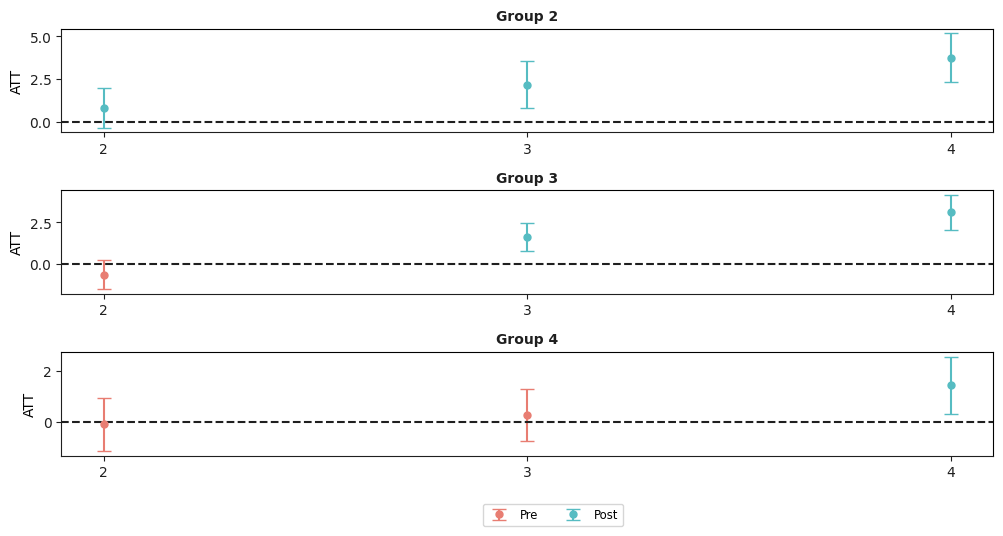

In [4]:
# plot the results
example_attgt.plot_attgt();

The resulting figure is one that contains separate plots for each group.  Notice in the figure above, the first plot is labeled "Group 2", the second "Group 3", etc.  Then, the figure contains estimates of group-time average treatment effects for each group in each time period along with a simultaneous confidence interval.  The red dots in the plots are pre-treatment pseudo group-time average treatment effects and are most useful for pre-testing the parallel trends assumption.  The blue dots are post-treatment group-time average treatment effects and should be interpreted as the average effect of participating in the treatment for units in a particular group at a particular point in time.

## Other features of the `csdid` package

The above discussion covered only the most basic case for using the `csdid` package.  There are a number of simple extensions that are useful in applications.  

### Adjustments for Multiple Hypothesis Testing

By default, the `csdid` package reports simultaneous confidence bands in plots of group-time average treatment effects with multiple time periods -- these are confidence bands that are robust to multiple hypothesis testing.  You can turn this off and compute analytical standard errors and corresponding figures with *pointwise* confidence intervals by setting `bstrap=False` in the call to `att_gt`...**but we don't recommend it**!


### Aggregating group-time average treatment effects

In many applications, there can be a large number of groups and time periods.  In this case, it may be infeasible to interpret plots of group-time average treatment effects.  The `csdid` package provides a number of ways to aggregate group-time average treatment effects using the `aggte` function.

#### Simple Aggregation

One idea that is likely to immediately come to mind is to just return a weighted average of all group-time average treatment effects with weights proportional to the group size.  This is available by calling the `aggte` function with `type = simple`.

In [5]:
example_attgt.aggte("simple")



   ATT Std. Error [95.0%  Conf. Int.]  
2.1061      0.235 1.6455       2.5668 *


---
Signif. codes: `*' confidence band does not cover 0
Control Group:  Never Treated , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust




This sort of aggregation immediately avoids the negative weights issue that two-way fixed effects regressions can suffer from, but we often think that *there are better alternatives*. In particular, this `simple` aggregation tends to overweight the effect of early-treated groups simply because we observe more of them during post-treatment periods.  We think there are likely to be better alternatives in most applications.




#### Group-Specific Effects

Another idea is to look at average effects specific to each group.  It is also straightforward to aggregate group-time average treatment effects into group-specific average treatment effects using the following code:



Overall summary of ATT's based on group/cohort aggregation:
   ATT Std. Error [95.0%  Conf. Int.]  
1.9512     0.2369 1.4868       2.4155 *


Group Effects:
   Group  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0      2    2.2547      0.4221           1.4274      3.0820  *
1      3    2.3531      0.2704           1.8232      2.8830  *
2      4    1.4397      0.4674           0.5236      2.3557  *
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  Never Treated , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust




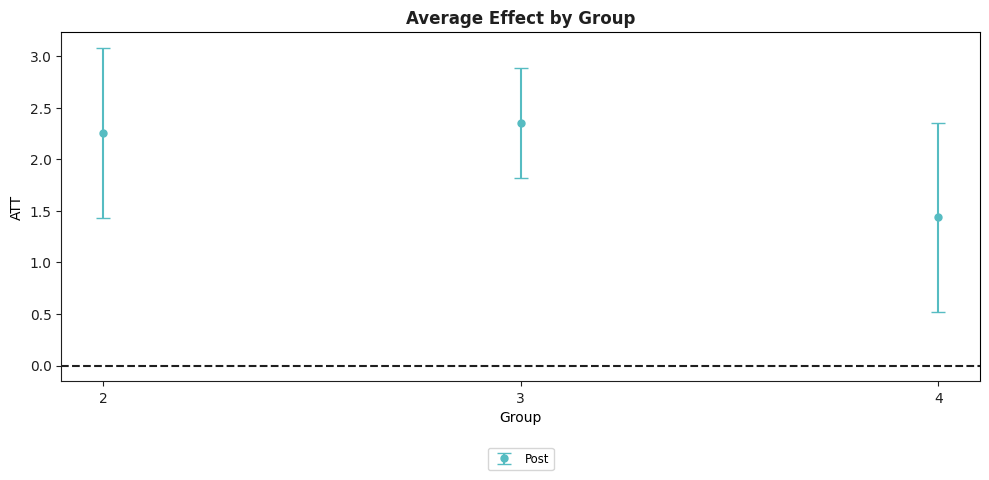

In [6]:
example_attgt.aggte("group")
example_attgt.plot_aggte();

In this figure, the y-axis is categorized by group.  The x-axis provides estimates of the average effect of participating in the treatment for units in each group averaged across all time periods after that group becomes treated.  In our example, the average effect of participating in the treatment is largest for group 2 -- this is because the effect of treatment here increases with length of exposure to the treatment, and they are the group that is exposed to the treatment for the longest.

The Overall ATT averages the group-specific treatment effects across groups.  In our view, *this parameter is a leading choice as an overall summary effect of participating in the treatment*. It is the average effect of participating in the treatment that was experienced across all units that participate in the treatment in any period.  In this sense, it has a similar interpretation to the ATT in the textbook case where there are exactly two periods and two groups.

#### Calendar Time Effects

Finally, the `csdid` package allows aggregations across different time periods.  To do this



Overall summary of ATT's based on calendar time aggregation:
   ATT Std. Error [95.0%  Conf. Int.]  
1.7349     0.2418 1.2611       2.2088 *


Time Effects (calendar):
   Time  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0     2    0.8363      0.4292          -0.0049      1.6775   
1     3    1.8209      0.3137           1.2060      2.4357  *
2     4    2.5477      0.3231           1.9144      3.1810  *
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  Never Treated , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust




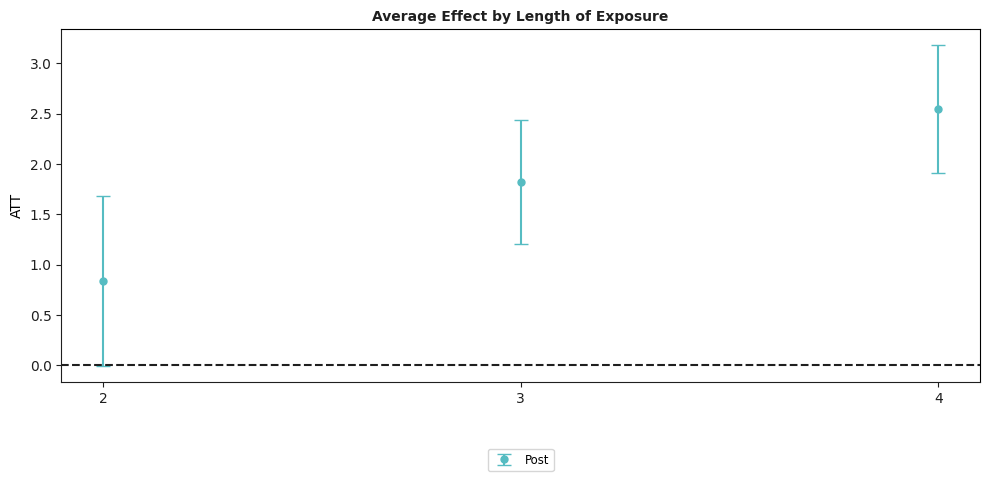

In [7]:
example_attgt.aggte('calendar')
example_attgt.plot_aggte();

In this figure, the x-axis is the time period and the estimates along the y-axis are the average effect of participating in the treatment in a particular time period for all groups that participated in the treatment in that time period.

### Small Group Sizes

Small group sizes can sometimes cause estimation problems in the `csdid` package.  To give an example, if there are any groups that have fewer observations than the number of covariates in the model, the code will error.  The `csdid` package reports a warning if there are any groups that have fewer than 5 observations. 

In addition, statistical inference, particularly on group-time average treatment may become more tenuous with small groups.  For example, the effective sample size for estimating the change in outcomes over time for individuals in a particular group is equal to the number of observations in that group and asymptotic results are unlikely to provide good approximations to the sampling distribution of group-time average treatment effects when the number of units in a group is small. In these cases, one should be very cautious about interpreting the $ATT(g,t)$ results for these small groups.

A reasonable alternative approach in this case is to just focus on aggregated treatment effect parameters (i.e., to run `aggte(..., type = "group")` or `aggte(...,type = "dynamic")`).  For each of these cases, the effective sample size is the total number of units that are ever treated.  As long as the total number of ever treated units is "large" (which should be the case for many DiD application), then the statistical inference results provided by the `csdid` package should be more stable.

### Selecting Alternative Control Groups

By default, the `csdid` package uses the group of units that never participate in the treatment as the control group.  In this case, if there is no group that never participates, then the `csdid` package will drop the last period and set units that do not become treated until the last period as the control group (this will also throw a warning).  The other option for the control group is to use the "not yet treated".  The "not yet treated" include the never treated as well as those units that, for a particular point in time, have not been treated yet (though they eventually become treated).  This group is at least as large as the never treated group though it changes across time periods.  To use the "not yet treated" as the control, set the option `control_group="notyettreated"`.

```python
example_attgt_altcontrol = ATTgt(
    yname="Y",
    tname="period",
    idname="id",
    gname="G",
    xformla="Y~X",
    data=dta,
    control_group="notyettreated"
).fit()
example_attgt_altcontrol.summ_attgt().summary2
```

### Repeated cross sections

The `csdid` package can also work with repeated cross section rather than panel data.  If the data is repeated cross sections, simply set the option `panel = False`.  In this case, `idname` is also ignored.  From a usage standpoint, everything else is identical to the case with panel data.

### Unbalanced Panel Data

By default, the `csdid` package takes in panel data and, if it is not balanced, coerces it into being a balanced panel by dropping units with observations that are missing in any time period.  However, if the user specifies the option `allow_unbalanced_panel = True`, then the `csdid` package will not coerce the data into being balanced.  Practically, the main cost here is that the computation time will increase in this case.  We also recommend that users think carefully about why they have an unbalanced panel before proceeding this direction.

### Alternative Estimation Methods

The `csdid` package implements all the $2 \times 2$ DiD estimators that are in the `DRDID` package.  By default, the `csdid` package uses "doubly robust" estimators that are based on first step linear regressions for the outcome variable and logit for the generalized propensity score.  The other options are "ipw" for inverse probability weighting and "reg" for regression.

In [8]:
example_attgt_reg = ATTgt(
    yname="Y",
    tname="period",
    idname="id",
    gname="G",
    xformla="Y~X",
    data=dta
    
).fit(est_method="reg")
example_attgt_reg.summ_attgt().summary2


,Group,Time,"ATT(g, t)",Post,Std. Error,[95% Pointwise,Conf. Band],
0,2,2,0.8373,0,0.4518,-0.3013,1.9759,
1,2,3,2.1842,0,0.5602,0.7721,3.5962,*
2,2,4,3.7435,0,0.5300,2.4077,5.0793,*
3,3,2,-0.6504,0,0.3889,-1.6305,0.3298,
4,3,3,1.6110,0,0.3247,0.7926,2.4294,*
5,3,4,3.0909,0,0.4031,2.0749,4.1070,*
6,4,2,-0.1072,0,0.4419,-1.2210,1.0065,
7,4,3,0.2528,0,0.4324,-0.8371,1.3426,
8,4,4,1.4357,0,0.4816,0.2217,2.6496,*


The argument `est_method` is also available to pass in a custom function for estimating DiD with 2 periods and 2 groups.  **Fair Warning:** this is very advanced use of the `csdid` package and should be done with caution.

# An example with real data

Next, we use a subset of data that comes from [Callaway and Sant'Anna (2020)](https://doi.org/10.1016/j.jeconom.2020.12.001).  This is a dataset that contains county-level teen employment rates from 2003-2007.  The data can be loaded by

In [9]:
mpdta = pd.read_csv("https://raw.githubusercontent.com/d2cml-ai/csdid/function-aggte/data/mpdta.csv")

`mpdta` is a balanced panel and the dataset looks like

In [10]:
mpdta.head()

,year,countyreal,lpop,lemp,first.treat,treat
0,2003,8001,5.896761,8.461469,2007,1
1,2004,8001,5.896761,8.336870,2007,1
2,2005,8001,5.896761,8.340217,2007,1
3,2006,8001,5.896761,8.378161,2007,1
4,2007,8001,5.896761,8.487352,2007,1


**Data Requirements**

In particular applications, the dataset should look like this with the key parts being:

* The dataset should be in *long* format -- each row corresponds to a particular unit at a particular point in time.  Sometimes panel data is in *wide* format -- each row contains all the information about a particular unit in all time periods.  

* There needs to be an id variable.  In `mpdta`, it is the variable `countyreal`.  This should not vary over time for particular units.  The name of this variable is passed to methods in the `csdid` package by setting, for example, `idname = "countyreal"`  

* There needs to be a time variable.  In `mpdta`, it is the variable `year`.  The name of this variable is passed to methods in the `csdid` package by setting, for example, `tname = "year"`

* In this application, the outcome is `lemp`.  The name of this variable is passed to methods in the `csdid` package by setting, for example, `yname = "lemp"`

* There needs to be a group variable.  In `mpdta`, it is the variable `first.treat`.  This is the time period when an individual first becomes treated.   *For individuals that are never treated, this variable should be set equal to 0.*  The name of this variable is passed to methods in the `csdid` package by setting, for example, `gname = "first.treat"`

* The `csdid` package allows for incorporating covariates so that the parallel trends assumption holds only after conditioning on these covariates.  In `mpdta`, `lpop` is the log of county population.  The `csdid` package requires that covariates be time-invariant.  For time varying covariates, the `csdid` package sets the value of the covariate to be equal to the value of the covariate in the "base period" where, in post-treatment periods the base period is the period immediately before observations in a particular group become treated (when there is anticipation, it is before anticipation effects start too), and in pre-treatment periods the base period is the period right before the current period.  Covariates are passed as a formula to the `csdid` package by setting, for example, `xformla = "lemp~lpop"`.  For estimators under unconditional parallel trends, the `xformla` argument can be left blank or can be set as `xformla = "lemp~1"` to only include a constant.

### The Effect of the Minimum Wage on Youth Employment

Next, we walk through a straightforward, but realistic way to use the `csdid` package to carry out an application.

**Side Comment:** This is just an example of how to use our method in a real-world setup.  To really evaluate the effect of the minimum wage on teen employment, one would need to be more careful along a number of dimensions. Thus, results displayed here should be interpreted as illustrative only.


We'll consider two cases.  For the first case, we will not condition on any covariates.  For the second, we will condition on the log of county population (in a "real" application, one might want to condition on more covariates).

In [11]:
# estimate group-time average treatment effects without covariates
mw_attgt = ATTgt(yname = "lemp",
              gname = "first.treat",
              idname = "countyreal",
              tname = "year",
              xformla = f"lemp~1",
              data = mpdta,
              panel = True,
              
              ).fit(est_method = 'reg')
mw_attgt.summ_attgt(n = 4).summary2

,Group,Time,"ATT(g, t)",Post,Std. Error,[95% Pointwise,Conf. Band],
0,2004,2004,-0.0105,0,0.0237,-0.0732,0.0522,
1,2004,2005,-0.0704,0,0.0323,-0.1559,0.0150,
2,2004,2006,-0.1373,0,0.0380,-0.2376,-0.0369,*
3,2004,2007,-0.1008,0,0.0362,-0.1966,-0.0050,*
4,2006,2004,0.0065,0,0.0241,-0.0572,0.0702,
5,2006,2005,-0.0028,0,0.0202,-0.0562,0.0507,
6,2006,2006,-0.0046,0,0.0181,-0.0525,0.0433,
7,2006,2007,-0.0412,0,0.0206,-0.0956,0.0131,
8,2007,2004,0.0305,0,0.0149,-0.0088,0.0698,
9,2007,2005,-0.0027,0,0.0169,-0.0474,0.0420,


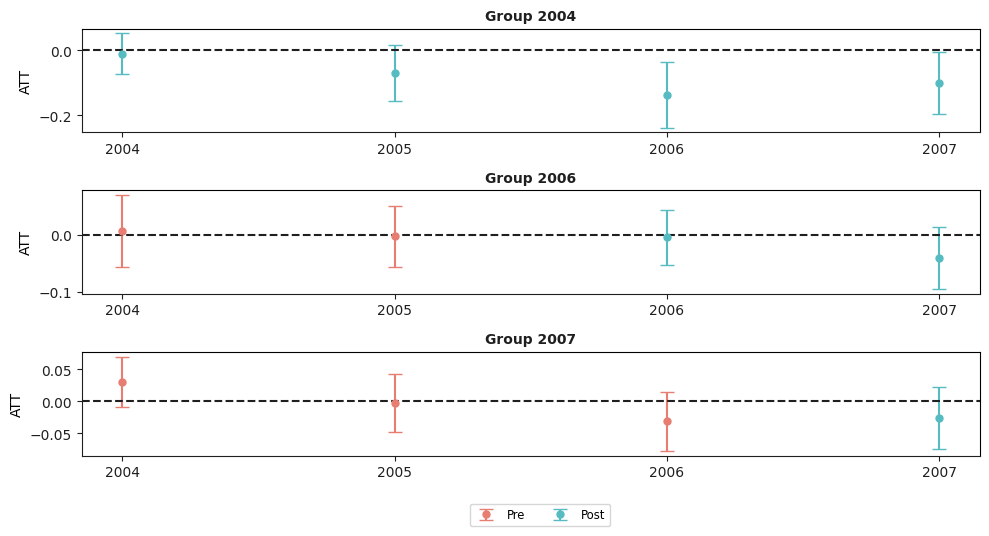

In [12]:
mw_attgt.plot_attgt();

There are a few things to notice in this case


* There is some evidence of negative effects of the minimum wage on employment.  Two group-time average treatment effects are negative and statistically different from 0.  These results also suggest that it may be helpful to aggregate the group-time average treatment effects.

In [13]:
mw_attgt.aggte('calendar')



Overall summary of ATT's based on calendar time aggregation:
    ATT Std. Error [95.0%  Conf. Int.]  
-0.0417     0.0175 -0.076      -0.0074 *


Time Effects (calendar):
   Time  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0  2004   -0.0105      0.0253          -0.0602      0.0392   
1  2005   -0.0704      0.0313          -0.1318     -0.0090  *
2  2006   -0.0488      0.0208          -0.0895     -0.0081  *
3  2007   -0.0371      0.0147          -0.0659     -0.0082  *
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  Never Treated , 
Anticipation Periods:  0
Estimation Method:  Outcome Regression




Finally, we can run all the same results including a covariate.  In this application the results turn out to be nearly identical, and here we provide just the code for estimating the group-time average treatment effects while including covariates.  The other steps are otherwise the same.

In [14]:
mw_attgt_X = ATTgt(yname = "lemp",
              gname = "first.treat",
              idname = "countyreal",
              tname = "year",
              xformla = f"lemp~lpop",
              data = mpdta,
              panel = True,
              
              ).fit(est_method = 'reg')
mw_attgt_X.summ_attgt(n = 4).summary2

,Group,Time,"ATT(g, t)",Post,Std. Error,[95% Pointwise,Conf. Band],
0,2004,2004,-0.0149,0,0.0236,-0.0783,0.0484,
1,2004,2005,-0.0770,0,0.0301,-0.1576,0.0036,
2,2004,2006,-0.1411,0,0.0377,-0.2420,-0.0401,*
3,2004,2007,-0.1075,0,0.0319,-0.1932,-0.0219,*
4,2006,2004,-0.0021,0,0.0214,-0.0594,0.0552,
5,2006,2005,-0.0070,0,0.0192,-0.0585,0.0445,
6,2006,2006,0.0008,0,0.0206,-0.0545,0.0560,
7,2006,2007,-0.0415,0,0.0196,-0.0941,0.0110,
8,2007,2004,0.0264,0,0.0136,-0.0100,0.0627,
9,2007,2005,-0.0048,0,0.0160,-0.0478,0.0383,


## Common Issues with the csdid package

We update this section with common issues that people run into when using the `csdid` package.  Please feel free to contact us with questions or comments.

* The `csdid` package is only built to handle staggered treatment adoption designs.  This means that once an individual becomes treated, they remain treated in all subsequent periods.

## Bugs

We also welcome (and encourage) users to report any bugs / difficulties they have using our code.